### First-pass at Random Forests for my metric-based model. 

In [1]:
#relevant import statements
import numpy as np
import math
import pandas as pd
import xarray as xr 
import pickle 
import matplotlib.pyplot as plt

import random
from random import seed
from random import randint
from random import sample

import seaborn as sns # statistical data visualization
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.feature_selection import SelectFromModel

In [2]:
##just to stop the excess number of warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
#load input data, it is max/min standardized, NaNs removed
infile = open("/network/rit/lab/langlab_rit/efernandez/Research/Dissertation/AI_Paper/ANN_2025/ANN_allMetrics/reduced_datafiles/nolag_normalized_input.p", 'rb') 
nolag_input = pickle.load(infile)
infile.close()

In [4]:
inp1 = np.empty((63,141,8)) #create new input array

In [5]:
##reshaping to change lag in metrics for input
inp1[:,:,0] = nolag_input[:,:141,0] ##wind
inp1[:,:,1] = nolag_input[:,:141,1] ##ratio
inp1[:,:,2] = nolag_input[:,:141,2] ##latitude
inp1[:,:,3] = nolag_input[:,:141,3] ##longitude
inp1[:,:,4] = nolag_input[:,:141,4] ##size
inp1[:,:,5] = nolag_input[:,:141,5] ##ephi
inp1[:,:,6] = nolag_input[:,:141,6] ##gph
inp1[:,:,7] = nolag_input[:,:141,7] ##pv

In [6]:
inp=inp1.reshape(63*141,8)

In [7]:
# weighted, temperature at 1000hPa over the area in europe
#infile = open("../../ANN_Folders/NovTake2/eur1000_temp.p", 'rb') 
infile = open("/network/rit/lab/langlab_rit/efernandez/Research/Dissertation/AI_Paper/ANN_2025/ANN_allMetrics/reduced_datafiles/eur_temp_avg.p", 'rb') 
temp = pickle.load(infile)
infile.close()

In [8]:
temp = temp.reshape(63,151) ##it was flattened, reshape it

In [9]:
##reshape again to introduce lag. 
output = temp[:,10:].reshape(63*141)
output.shape

(8883,)

In [10]:
output

array([1., 1., 1., ..., 0., 0., 1.])

In [11]:
#convert to pandas dataframe
input = pd.DataFrame(inp)

In [12]:
input ##print

,0,1,2,3,4,5,6,7
0,0.416020,0.626469,0.943680,0.883691,0.276044,0.758745,0.173212,0.263655
1,0.415984,0.654421,0.955515,0.920671,0.268594,0.755405,0.224607,0.280078
2,0.414214,0.701460,0.956576,0.618719,0.267456,0.752030,0.323652,0.276016
3,0.412009,0.635060,0.910781,0.589108,0.237092,0.754007,0.395994,0.255845
4,0.414312,0.686418,0.917111,0.482064,0.251878,0.759211,0.424932,0.250102
...,...,...,...,...,...,...,...,...
8878,0.646782,0.545618,0.922284,0.681559,0.632386,0.770870,0.188546,0.348729
8879,0.613995,0.574641,0.922637,0.690485,0.619939,0.768426,0.198028,0.398339
8880,0.577320,0.607609,0.919291,0.704035,0.611072,0.779759,0.218581,0.473854
8881,0.544127,0.654108,0.911172,0.720415,0.602780,0.797732,0.235237,0.558456


In [13]:
#label columns of variables for input data
col_names = ['wind','rat','cenlat','cenlon','size','ephi','gph','pv']
input.columns = col_names

input

,wind,rat,cenlat,cenlon,size,ephi,gph,pv
0,0.416020,0.626469,0.943680,0.883691,0.276044,0.758745,0.173212,0.263655
1,0.415984,0.654421,0.955515,0.920671,0.268594,0.755405,0.224607,0.280078
2,0.414214,0.701460,0.956576,0.618719,0.267456,0.752030,0.323652,0.276016
3,0.412009,0.635060,0.910781,0.589108,0.237092,0.754007,0.395994,0.255845
4,0.414312,0.686418,0.917111,0.482064,0.251878,0.759211,0.424932,0.250102
...,...,...,...,...,...,...,...,...
8878,0.646782,0.545618,0.922284,0.681559,0.632386,0.770870,0.188546,0.348729
8879,0.613995,0.574641,0.922637,0.690485,0.619939,0.768426,0.198028,0.398339
8880,0.577320,0.607609,0.919291,0.704035,0.611072,0.779759,0.218581,0.473854
8881,0.544127,0.654108,0.911172,0.720415,0.602780,0.797732,0.235237,0.558456


In [14]:
input.info() ##checking for NaNs again ....

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8883 entries, 0 to 8882
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wind    8883 non-null   float64
 1   rat     8883 non-null   float64
 2   cenlat  8883 non-null   float64
 3   cenlon  8883 non-null   float64
 4   size    8883 non-null   float64
 5   ephi    8883 non-null   float64
 6   gph     8883 non-null   float64
 7   pv      8883 non-null   float64
dtypes: float64(8)
memory usage: 555.3 KB


<Axes: >

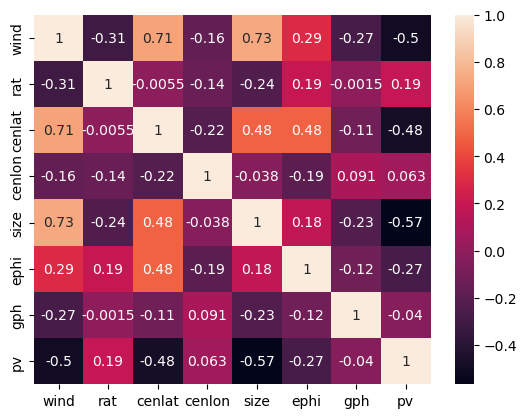

In [15]:
sns.heatmap(input.corr(), annot=True) ##heatmap for showing correlation across variables

### Start Random Forest Model. 

In [16]:
##first ... split data into training/testing ...
##this is just taking the first 58 years of data, leaving the remaining 5 for testing
X_train = input.iloc[:(58*141),:]
X_test = input.iloc[(58*141):,:]
Y_train = output[:(58*141)]
Y_test = output[(58*141):]

val_subset = (5*141) #index for subsetting validation data in cross val

In [17]:
X_train.describe()

,wind,rat,cenlat,cenlon,size,ephi,gph,pv
count,8178.000000,8178.000000,8178.000000,8178.000000,8178.000000,8178.000000,8178.000000,8178.000000
mean,0.514118,0.511941,0.879169,0.660423,0.606124,0.624269,0.458907,0.270335
std,0.143824,0.091614,0.065545,0.145065,0.175629,0.243100,0.150998,0.127227
min,0.000000,0.330801,0.594425,0.000000,0.035200,0.000000,0.000000,0.000000
25%,0.416618,0.443351,0.844376,0.582237,0.480778,0.455652,0.353695,0.184303
50%,0.507687,0.498395,0.890292,0.687250,0.628401,0.698729,0.447550,0.253839
75%,0.610944,0.564250,0.926236,0.761620,0.740555,0.817472,0.553150,0.331078
max,1.000000,1.000000,0.994664,1.000000,1.000000,1.000000,1.000000,0.967684


In [18]:
#empty lists to save MSE, Accuracy, and R2
mse_reg1_val = []
r2_reg1_val = []
acc_reg1_val = []

mse_reg1_train = []
r2_reg1_train = []
acc_reg1_train = []

mse_reg1_test = []
r2_reg1_test = []
acc_reg1_test = []

important = np.empty((100,8))

In [19]:
#save PREDICTIONS
valP = []
testP = []
trainP = []

### Quick hyperparameter tuning intermission:

In [20]:
from sklearn.model_selection import GridSearchCV

#hyper parameter grid for testing
params = {
    'n_estimators': np.arange(100,500,100).tolist(), ##number of hidden decision trees
    'max_depth':np.arange(1,20,1).tolist(), #number of branches down allowed. 
}

In [21]:
#GridSearchCV for tuning
tuning = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=3)

#fit to training data
tuning.fit(X_train.iloc[val_subset:,:], Y_train[val_subset:]) ##subset validation so the first five years are used for validation here 

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'n_estimators': [100, 200, 300, 400]})

In [22]:
#show best params
best_rf = tuning.best_estimator_
best_rf

##max 3, n 250

RandomForestClassifier(max_depth=3, n_estimators=400, random_state=42)

In [24]:
##try on validation data
val_pred_test = best_rf.predict(X_train.iloc[:val_subset,:])
val_accuracy = accuracy_score(Y_train[:val_subset], val_pred_test)
                             
print(f"Tuned Params Validation Accuracy: {val_accuracy}")

Tuned Params Validation Accuracy: 0.5900709219858156


Okay... Now run it! 

In [25]:
#create initial regressor for rf to do feature selection 
rf_reg1 = RandomForestClassifier(max_depth=3, n_estimators=400, random_state=42)

In [26]:
##make loop for cross validation 
for l in range(0,100):
    print("Cross Val #:"+str(l))
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_train.iloc[:,0])-val_subset)
    end = start+(val_subset)

    X_val = input.iloc[start:end,:]
    Y_val = output[start:end]
    
    X_train1 = X_train.iloc[0:start]
    Y_train1 = Y_train[0:start]
    X_train2 = X_train.iloc[end:]
    Y_train2 = Y_train[end:]

    ##concatenate all of these
    X_tr = pd.concat([X_train1,X_train2], axis = 0)
    Y_tr = np.concatenate((Y_train1,Y_train2))

    #train rf
    rf_reg1.fit(X_tr, Y_tr)
    
    #prediction with validation data
    pred_val = rf_reg1.predict(X_val)
    valP.append(pred_val)
    mse_reg1_val.append(mean_squared_error(Y_val, pred_val))
    r2_reg1_val.append(r2_score(Y_val, pred_val))
    acc_reg1_val.append(accuracy_score(Y_val, pred_val))
    
    #prediction with training data
    pred_train = rf_reg1.predict(X_tr)
    trainP.append(pred_train)
    mse_reg1_train.append(mean_squared_error(Y_tr, pred_train))
    r2_reg1_train.append(r2_score(Y_tr, pred_train))
    acc_reg1_train.append(accuracy_score(Y_tr, pred_train))

    #prediction with testing data
    pred_test = rf_reg1.predict(X_test)
    testP.append(pred_test)
    mse_reg1_test.append(mean_squared_error(Y_test, pred_test))
    r2_reg1_test.append(r2_score(Y_test, pred_test))
    acc_reg1_test.append(accuracy_score(Y_test, pred_test))

    #prepare to show relevant features by actually ... choosing them 
    selector = SelectFromModel(rf_reg1, threshold="mean", max_features=None)
    X_train_selected = selector.transform(X_tr)
    X_test_selected = selector.transform(X_test)

    #print names of selected features
    selected_features = input.columns[selector.get_support()]
    print(f'Selected Features: {selected_features}')

    importances = rf_reg1.feature_importances_
    important[l,:] = importances[:]

Cross Val #:0
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:1
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:2
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:3
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:4
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:5
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:6
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:7
Selected Features: Index(['wind', 'cenlon', 'size', 'pv'], dtype='object')
Cross Val #:8
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:9
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:10
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:11
Selected Features: Index(['wind', 'cenlon', 'size', 'pv'], dtype=

In [27]:
pred_test = rf_reg1.predict_proba(X_test)

In [28]:
pred_test

array([[0.42564407, 0.57435593],
       [0.43150717, 0.56849283],
       [0.4254792 , 0.5745208 ],
       ...,
       [0.40728792, 0.59271208],
       [0.38644792, 0.61355208],
       [0.37847648, 0.62152352]])

In [29]:
print(f'Mean Squared Error, Validation: {np.mean(mse_reg1_val)}')
print(f'Mean Squared Error, Training: {np.mean(mse_reg1_train)}')
print(f'Mean Squared Error, Testing: {np.mean(mse_reg1_test)}')
print('###################################################')
print(f'R-squared, Validation: {np.mean(r2_reg1_val)}')
print(f'R-squared, Training: {np.mean(r2_reg1_train)}')
print(f'R-squared, Testing: {np.mean(r2_reg1_test)}')
print('###################################################')
print(f'Accuracy, Validation: {np.mean(acc_reg1_val) * 100:.2f}%')
print(f'Accuracy, Training: {np.mean(acc_reg1_train) * 100:.2f}%')
print(f'Accuracy, Testing: {np.mean(acc_reg1_test) * 100:.2f}%')

Mean Squared Error, Validation: 0.3841418439716312
Mean Squared Error, Training: 0.36928542753914095
Mean Squared Error, Testing: 0.39344680851063835
###################################################
R-squared, Validation: -0.5406100267398434
R-squared, Training: -0.4771791807122582
R-squared, Testing: -0.5738663983903423
###################################################
Accuracy, Validation: 61.59%
Accuracy, Training: 63.07%
Accuracy, Testing: 60.66%


In [25]:
#take average across all feature importance values by cross validation
imp = np.nanmean(important, axis = 0)
imp.shape

(8,)

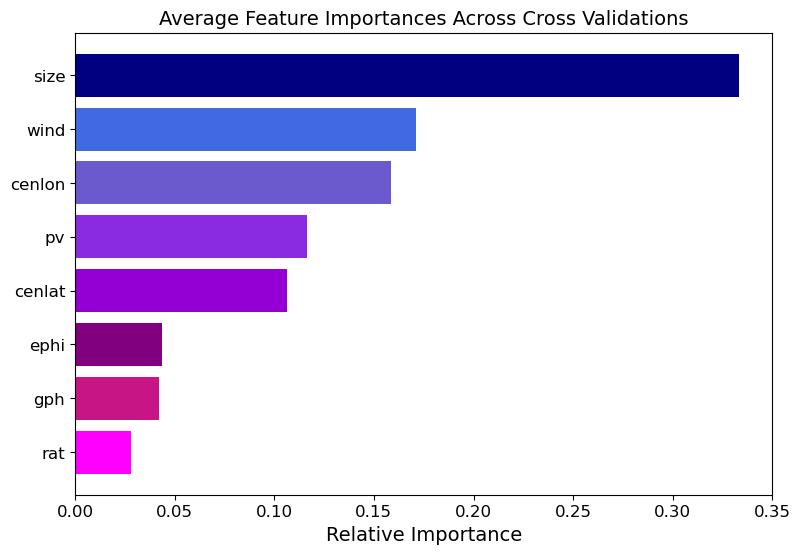

In [47]:
#plot features by relative importance
indices = np.argsort(imp)[::-1]  #sort by importance
c = ["navy","royalblue","slateblue","blueviolet","darkviolet","purple","mediumvioletred","magenta"]

plt.figure(figsize=(9, 6))
plt.title("Average Feature Importances Across Cross Validations",fontsize =14)
plt.barh(range(input.shape[1]), imp[indices], align="center", color = c)
plt.yticks(range(input.shape[1]), input.columns[indices],fontsize =12)
plt.xticks(fontsize =12)
plt.xlabel("Relative Importance",fontsize =14)
plt.gca().invert_yaxis()
plt.savefig("RF_FeatureImportance_GPHlag.png")

In [27]:
##change pandas dataframe to choose top 3 important features only
input2 = input[['size', "wind", "cenlon"]]
#input2 = input

In [28]:
#AGAIN, empty lists to save MSE, Accuracy, and R2
mse_reg2_val = []
r2_reg2_val = []
acc_reg2_val = []

mse_reg2_train = []
r2_reg2_train = []
acc_reg2_train = []

mse_reg2_test = []
r2_reg2_test = []
acc_reg2_test = []

#save PREDICTIONS
test90_acc = []
##full model
fulltest_acc = []

##correct positive
posXtest = []
#false positive
FposXtest = []
#correct negative
negXtest = []
#false negative
FnegXtest = []

indexes = []


##correct positive
percpos = []
#false positive
percFpos = []
#correct negative
percneg = []
#false negative
percFneg = []

In [29]:
##first ... split data into training/testing ...
##this is just taking the first 58 years of data, leaving the remaining 5 for testing
X_train = input2.iloc[:(58*141),:]
X_test = input2.iloc[(58*141):,:]
Y_train = output[:(58*141)]
Y_test = output[(58*141):]

val_subset = (5*141) #index for subsetting validation data in cross val

In [30]:
##definition statement for ACC
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

In [31]:
import keras
Y_tes = keras.utils.to_categorical(Y_test)

2025-03-12 22:11:16.622843: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 22:11:16.667368: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-12 22:11:16.667394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-12 22:11:16.668999: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 22:11:16.677111: I tensorflow/core/platform/cpu_feature_guar

In [32]:
#second random forest model with selected features only
rf_reg2 = RandomForestClassifier(max_depth=3, n_estimators=250, random_state=42)

In [33]:
##make loop for cross validation 
for l in range(0,100):
    print("Cross Val #:"+str(l))
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_train.iloc[:,0])-val_subset)
    end = start+(val_subset)

    X_val = input2.iloc[start:end,:]
    Y_val = output[start:end]
    
    X_train1 = X_train.iloc[0:start]
    Y_train1 = Y_train[0:start]
    X_train2 = X_train.iloc[end:]
    Y_train2 = Y_train[end:]

    ##concatenate all of these
    X_tr = pd.concat([X_train1,X_train2], axis = 0)
    Y_tr = np.concatenate((Y_train1,Y_train2))

    #train rf
    rf_reg2.fit(X_tr, Y_tr)
    
   #prediction with validation data
    pred_val = rf_reg2.predict(X_val)
    mse_reg2_val.append(mean_squared_error(Y_val, pred_val))
    r2_reg2_val.append(r2_score(Y_val, pred_val))
    acc_reg2_val.append(accuracy_score(Y_val, pred_val))
    
    #prediction with training data
    pred_train = rf_reg2.predict(X_tr)
    mse_reg2_train.append(mean_squared_error(Y_tr, pred_train))
    r2_reg2_train.append(r2_score(Y_tr, pred_train))
    acc_reg2_train.append(accuracy_score(Y_tr, pred_train))

    #prediction with testing data
    pred_test = rf_reg2.predict(X_test)
    test = rf_reg2.predict_proba(X_test)
    mse_reg2_test.append(mean_squared_error(Y_test, pred_test))
    r2_reg2_test.append(r2_score(Y_test, pred_test))
    acc_reg2_test.append(accuracy_score(Y_test, pred_test))

    q90 = np.percentile(test,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(test) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test90 = test[great90]
    test90_norm = Y_tes[great90]
    test90_acc.append(calculate_accuracy(test90_norm, test90, threshold=0.5))
    ##full model
    fulltest_acc.append(calculate_accuracy(Y_tes, test, threshold=0.5))

    ##classify the accuracy of predicitons
    correct_pos = [] #correct positive anomaly
    correct_neg = [] #correct negative anomaly
    
    false_pos = [] #false positive
    false_neg = [] #false negative

    indexes.extend(great90)
    for j in range(len(great90)):
        #print(j)
        #print(great90[j])
        index = great90[j]
        if test[index,0] < test[index,1] and Y_tes[index,0] == 0:
            correct_pos.append(index)
            #print('###########')
        elif test[index,0] > test[index,1] and Y_tes[index,0] == 1:
            correct_neg.append(index)
            #print('###########')
        elif test[index,0] < test[index,1] and Y_tes[index,0] == 1:
            false_neg.append(index)
            #print('###########')
        elif test[index,0] > test[index,1] and Y_tes[index,0] == 0:
            false_pos.append(index)
            #print('###########')

    ##correct positive
    posXtest.extend(correct_pos)
    #false positive
    FposXtest.extend(false_pos)
    #correct negative
    negXtest.extend(correct_neg)
    #false negative
    FnegXtest.extend(false_neg)
    
    percpos.append(len(correct_pos)/len(great90))
    #false positive
    percFpos.append(len(false_pos)/len(great90))
    #correct negative
    percneg.append(len(correct_neg)/len(great90))
    #false negative
    percFneg.append(len(false_neg)/len(great90))



Cross Val #:0
Cross Val #:1
Cross Val #:2
Cross Val #:3
Cross Val #:4
Cross Val #:5
Cross Val #:6
Cross Val #:7
Cross Val #:8
Cross Val #:9
Cross Val #:10
Cross Val #:11
Cross Val #:12
Cross Val #:13
Cross Val #:14
Cross Val #:15
Cross Val #:16
Cross Val #:17
Cross Val #:18
Cross Val #:19
Cross Val #:20
Cross Val #:21
Cross Val #:22
Cross Val #:23
Cross Val #:24
Cross Val #:25
Cross Val #:26
Cross Val #:27
Cross Val #:28
Cross Val #:29
Cross Val #:30
Cross Val #:31
Cross Val #:32
Cross Val #:33
Cross Val #:34
Cross Val #:35
Cross Val #:36
Cross Val #:37
Cross Val #:38
Cross Val #:39
Cross Val #:40
Cross Val #:41
Cross Val #:42
Cross Val #:43
Cross Val #:44
Cross Val #:45
Cross Val #:46
Cross Val #:47
Cross Val #:48
Cross Val #:49
Cross Val #:50
Cross Val #:51
Cross Val #:52
Cross Val #:53
Cross Val #:54
Cross Val #:55
Cross Val #:56
Cross Val #:57
Cross Val #:58
Cross Val #:59
Cross Val #:60
Cross Val #:61
Cross Val #:62
Cross Val #:63
Cross Val #:64
Cross Val #:65
Cross Val #:66
Cross

In [34]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable


In [35]:
print(f'Mean Squared Error, Validation: {np.mean(mse_reg2_val)}')
print(f'Mean Squared Error, Training: {np.mean(mse_reg2_train)}')
print(f'Mean Squared Error, Testing: {np.mean(mse_reg2_test)}')
print('###################################################')
print(f'R-squared, Validation: {np.mean(r2_reg2_val)}')
print(f'R-squared, Training: {np.mean(r2_reg2_train)}')
print(f'R-squared, Testing: {np.mean(r2_reg2_test)}')
print('###################################################')
print(f'Accuracy, Validation: {np.mean(acc_reg2_val) * 100:.2f}%')
print(f'Accuracy, Training: {np.mean(acc_reg2_train) * 100:.2f}%')
print(f'Accuracy, Testing: {np.mean(acc_reg2_test) * 100:.2f}%')

Mean Squared Error, Validation: 0.3922127659574469
Mean Squared Error, Training: 0.3722668272447478
Mean Squared Error, Testing: 0.40072340425531905
###################################################
R-squared, Validation: -0.5724590803018426
R-squared, Training: -0.48909907381088447
R-squared, Testing: -0.6029742454728373
###################################################
Accuracy, Validation: 60.78%
Accuracy, Training: 62.77%
Accuracy, Testing: 59.93%


In [36]:
#try SHAP with this model
import shap

explainer = shap.TreeExplainer(rf_reg2)

In [37]:
shap_values = explainer.shap_values(X_test)
shap_obj = explainer(X_test)

In [38]:
shap_obj.shape

(705, 3, 2)

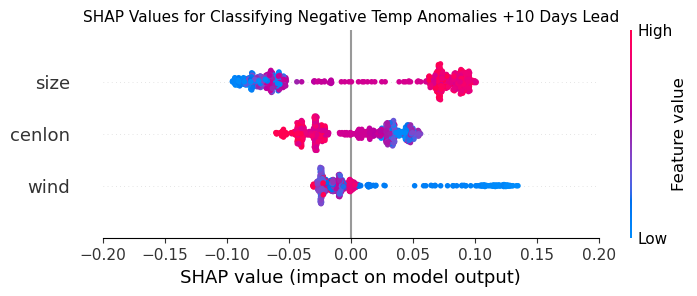

In [48]:
plt.title("SHAP Values for Classifying Negative Temp Anomalies +10 Days Lead",fontsize =11)
ax = shap.plots.beeswarm(shap_obj[:,:,0], show = False) ##for negative classifications ... this is physically consistent!
ax.set_xlim(-0.2,0.2)

plt.savefig("RFshap_Neg_Pred_GPHlag.png")

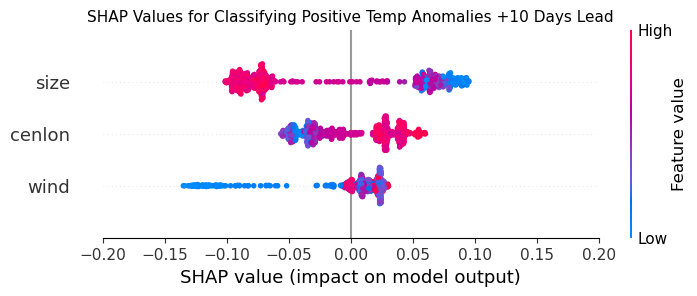

In [49]:
plt.title("SHAP Values for Classifying Positive Temp Anomalies +10 Days Lead",fontsize =11)
ax = shap.plots.beeswarm(shap_obj[:,:,1], show = False) ##for positive classifications ... this is physically consistent!
ax.set_xlim(-0.2,0.2)
plt.savefig("RFshap_Pos_Pred_GPHlag.png")

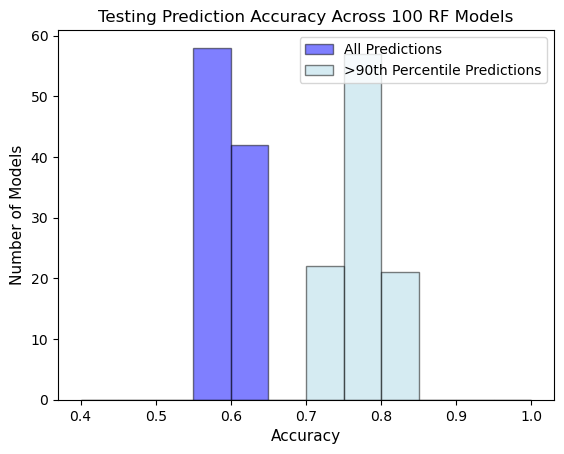

In [50]:
#######bar plot for showing the distribution of confident predictions
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(test90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltest_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy',fontsize =11)
plt.ylabel('Number of Models',fontsize =11)
plt.legend()
plt.title('Testing Prediction Accuracy Across 100 RF Models',fontsize =12)
plt.savefig("RF_PredACCtest_GPHlag.png")

In [42]:
##correct positive
posXtest = np.array(posXtest)
#false positive
FposXtest = np.array(FposXtest)
#correct negative
negXtest = np.array(negXtest)
#false negative
FnegXtest = np.array(FnegXtest)

indexes = np.array(indexes)

In [43]:
print(f'Average Num. of 10% Confident and Correct Postive Predictions: {np.mean(percpos)* 100:.2f}%')
print(f'Average Num. of 10% Confident and Correct Negative Predictions: {np.mean(percneg)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Postive Predictions: {np.mean(percFpos)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Negative Predictions: {np.mean(percFneg)* 100:.2f}%')
print('#######################################################################')
print(f'Average Num. of 10% Confident and Correct Predictions: {np.mean(percpos)* 100 + np.mean(percneg)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Predictions: {np.mean(percFpos)* 100 +np.mean(percFneg)* 100:.2f}%')

Average Num. of 10% Confident and Correct Postive Predictions: 36.36%
Average Num. of 10% Confident and Correct Negative Predictions: 41.26%
Average Num. of 10% Confident and FALSE Postive Predictions: 8.71%
Average Num. of 10% Confident and FALSE Negative Predictions: 13.67%
#######################################################################
Average Num. of 10% Confident and Correct Predictions: 77.61%
Average Num. of 10% Confident and FALSE Predictions: 22.39%


In [44]:
####now I wanna make these plots SO ... I am adding an index column on to X_test ... full version. 
X_test = input.iloc[(58*141):,:]
ranges = np.array([x for x in range(0,705,1)])
ranges = ranges.reshape(5,141) 
ranges.shape

(5, 141)

In [45]:
ranges[0,0:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [46]:
##export out files to make the next few plots w/o normalization
pickle.dump(ranges, open("range_indices_RF3.p", 'wb'))
pickle.dump(posXtest, open("posXtest_RF3.p", 'wb'))
pickle.dump(FposXtest, open("FposXtest_RF3.p", 'wb'))
pickle.dump(negXtest, open("negXtest_RF3.p", 'wb'))
pickle.dump(FnegXtest, open("FnegXtest_RF3.p", 'wb'))

In [47]:
nolag_Xtest = nolag_input[58:,:,:]
nolag_Xtest.shape

(5, 151, 8)

In [48]:
##Correct Positive Events
pos_corr_events = []
pos_corr_num = []
pos_corr_total_events = []

for i in range(0,5):
    for j in range(0,141):
        #index for the date being observed
        date_index = ranges[i,j]
        ##loop through indexes of positive and correct events
        for k in range(len(posXtest)):
            pos_index = posXtest[k]
            if pos_index == date_index:
                pos_corr_total_events.append(0)
                if j<=19:
                    continue
                else:
                    pos_corr_num.append(0)
                    pos_corr_events.extend(nolag_Xtest[i,j-20:j,:])

In [49]:
##Correct Negative Events
neg_corr_events = []
neg_corr_num = []
neg_corr_total_events = []

for i in range(0,5):
    for j in range(0,141):
        #index for the date being observed
        date_index = ranges[i,j]
        ##loop through indexes of positive and correct events
        for k in range(len(negXtest)):
            neg_index = negXtest[k]
            if neg_index == date_index:
                neg_corr_total_events.append(0)
                if j<=19:
                    continue
                else:
                    neg_corr_num.append(0)
                    neg_corr_events.extend(nolag_Xtest[i,j-20:j,:])

In [50]:
pos = np.array(pos_corr_events).reshape((len(pos_corr_num),20,8))
print(pos.shape)
print(len(pos_corr_total_events))
##A LOT OF THE CORRECT POSITIVE EVENTS ARE WITHIN 20 DAYS OF THE START OF THE YEAR

(1328, 20, 8)
4964


In [51]:
neg = np.array(neg_corr_events).reshape((len(neg_corr_num),20,8))
print(neg.shape)
print(len(neg_corr_total_events))

(4877, 20, 8)
4877


In [52]:
##wind
##ratio
##latitude
##longitude
##size
##ephi
##gph
##pv

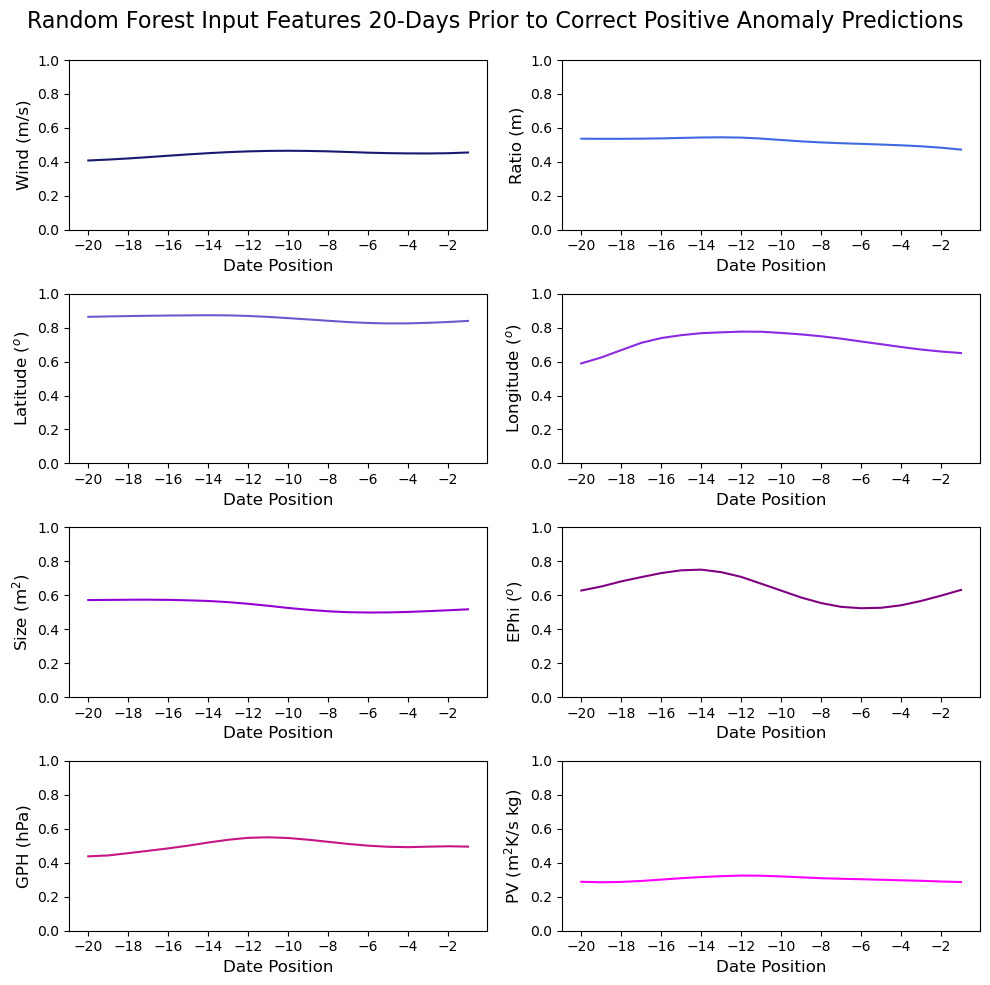

In [53]:
import matplotlib.ticker as mticker
myLocator = mticker.MultipleLocator(2)
l2 = [-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]
metrics = ["Wind (m/s)", "Ratio (m)", "Latitude ($^o$)", "Longitude ($^o$)", "Size (m$^2$)", "EPhi ($^o$)", "GPH (hPa)", "PV (m$^2$K/s kg)"]
c = ["midnightblue","royalblue","slateblue","blueviolet","darkviolet","purple","mediumvioletred","magenta"]
fs = 12

fig, axes = plt.subplots(4, 2, figsize=(10, 10))
plt.suptitle("Random Forest Input Features 20-Days Prior to Correct Positive Anomaly Predictions", fontsize = 16)
axes = axes.flatten()
for i in range(0,8):
    
    element = pos[:,:,i]
    inp = np.nanmean(element,axis=0)
    axes[i].plot(l2, inp, color = str(c[i]))
    axes[i].set_ylabel(str(metrics[i]), fontsize = fs)
    axes[i].set_xlabel("Date Position", fontsize = fs)
    axes[i].set_ylim(0,1)
    axes[i].xaxis.set_major_locator(myLocator)
    

plt.tight_layout()
plt.subplots_adjust(top=0.93)   
plt.savefig("PosCorr.png")
plt.show()